In [ ]:
#######################################################################
# MED 263:Bioinformatics Applications to Human Disease (Winter 2022)  #
# Analysis of epigenetic data for precision cancer diagnosis          #
# Lukas Chavez, Jan 2023                                              #
# UC San Diego                                                        #
#######################################################################

# Tested with 
# RStudio Version 2022.12.0+353  and 
# R version 4.2.2 (2022-10-31) -- "Innocent and Trusting"
# macOS Ventura 13.1

#Data used in this class is available at: https://www.dropbox.com/sh/qlguyj3pja030eg/AADxsUoamhboLX-Tcwl7Lvjoa?dl=0

# For the homework you will need an account at https://notebook.genepattern.org/

#Required R packages (see below for instructions how to install these packages)
# BioC core packages
# GenomicFeatures
# minfi
# minfiData
# Rtsne
# sva

In [ ]:
# package manager for the bioconductor software ecosystem
if (!require("BiocManager", quietly = TRUE)){
    install.packages("BiocManager")
}

# Install BioC core packages
BiocManager::install(version = "3.16")

#Install specific packages
BiocManager::install(c("GenomicFeatures"))
BiocManager::install(c("minfi", "minfiData", "sva", "Rtsne"))

In [1]:
library(minfi) # Package for loading and preprocessing methylation data from many sources including Illumina. See https://bioconductor.org/packages/devel/bioc/vignettes/minfi/inst/doc/minfi.html
library(minfiData) # Example dataset for minfi vignette.
library(conumee) # Package for estimating genomic copy number from methylation. See https://bioconductor.org/packages/devel/bioc/vignettes/conumee/inst/doc/conumee.html
library(Rtsne) # t-stochastic neighbor embedding.
library(sva) # one of many batch correction algorithms
library(tictoc) # System time functions tic() and toc()

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: M

In [ ]:
#Identify Illumina Infinium raw data (idat files)
# Set manually:
baseDir <- system.file("extdata", package = "minfiData")

In [ ]:
#Warm-up exercises:
########################
#1.1) Show the location/path and content of baseDir. What are the R commands?
#1.2) How many arrays and how many samples are in the example data?
###########################

#None of the following will work when minfi and minfidata cannot be installed

#Import sample sheet
targets <- minfi::read.metharray.sheet(baseDir)

#Import entire metharray experiment using a sample sheet and returns an RGChannelSet (RGSet) object
RGSet <- minfi::read.metharray.exp(targets = targets)

#Sample information
phenoData <- Biobase::pData(RGSet)

#The manifest contains the information and annotation of the probes on the array
manifest <- minfi::getManifest(RGSet)

In [ ]:
# You can view documentation using ?
class(RGSet) # get the type of a variable
?RGChannelSet # view the documentation of that type

In [ ]:
#1.3) Fill in the numbers:
###########################
#Number of type I probes:  
#Number of type II probes:  
#Number of control probes:  
###########################

#Creation of a MethylSet without normalization
MSet <- preprocessRaw(RGSet) 

#Show matrix of methylation values
#methylated channel
head(getMeth(MSet)[,1:6])
dim(getMeth(MSet))

#unmethylated channel
head(getUnmeth(MSet)[,1:6])
dim(getUnmeth(MSet))

#Converting methylation data from methylation and unmethylation channels, to ratios (Beta-values).
#Returns a ratioSet
RSet <- ratioConvert(MSet, what = "both", keepCN = TRUE)

#Extracts beta values
beta <- getBeta(RSet)

head(beta)

In [ ]:
########################
#1.4) How many probes are on the array? Is the example data 450k or 850k data?
###########################

#Map methylation data to the genome
#Returns a GenomicRatioSet
GRset <- mapToGenome(RSet)

#Create new beta matrix based on ordered probes mapped to the genome
beta <- getBeta(GRset)

#Genomic locations of probes
gr <- granges(GRset)

In [ ]:
########################
#1.5) What is the "cg" ID of the first probe on chromosome 1 (chr1, position 15,865)
###########################

#Access sample information from GRset
sampleNames <- sampleNames(GRset)
probeNames <- featureNames(GRset)
pheno <- pData(GRset)

#Estimate sample-specific quality control (QC) for methylation data
qc <- getQC(MSet)
plotQC(qc)

#Distribution of beta values
densityPlot(MSet, sampGroups = phenoData$Sample_Group)
densityBeanPlot(MSet, sampGroups = phenoData$Sample_Group)

In [ ]:
########################
#1.6) One of the two groups (Group A and Group B) seem to have a slight increase in probes that have an intermediate methylation (0.2-0.6 beta). 
# Are those the normal or the cancer samples?
###########################

#Biological sex prediction
#med(X) = median total intensity of the X chromosome-mapped probes
#med(Y) = median total intensity of the Y chromosome-mapped probes
predictedSex <- getSex(GRset, cutoff = -2)


In [ ]:
########################
#1.7) Is sample 5723646053_R05C02 likely male or female? 
#1.8) True or false: The ratio of median measurements on the two sex chromosomes (xMed, yMed) is closer to 1 for male samples.
###########################

In [ ]:
#################################################################
# Exercise II
# Stratification of patient medulloblastoma tumors by
# clustering of Illumina Infinium DNA methylation array data
#################################################################
#Data published by Northcott et al., The whole-genome landscape of medulloblastoma subtypes, Nature 2017
#Raw microarray available (access controlled, don't distribute) at European Genome-Phenome Archive (EGA, http://www.ebi.ac.uk/ega/), under accession number EGAS00001001953.

In [2]:
# Load preprocessed beta values of 1,256 medulloblastoma patients stored 
# in the file MBlandscape_completed_unique.RData (provided with course material)
tic("Load MB dataset")
load("data/MBlandscape_completed_unique.RData") #load the object 'allbeta'
toc()

Load MB dataset: 26.744 sec elapsed


In [3]:
# For each CpG, calculate the standard deviation across the cohort and
# order the CpGs according to their standard deviation (from top to bottom)
# This takes awhile
tic("Order CpG sites by variance")
allbeta.sd <- apply(allbeta, 1, sd, na.rm=TRUE)
allbeta.ordered <- allbeta[order(allbeta.sd, decreasing=TRUE),]
head(allbeta.ordered)
toc()

,111123_Jones_all96_SampleMethylationProfile_allData_noAnnol.4M28,111123_Jones_all96_SampleMethylationProfile_allData_noAnnol.4M8,111123_Jones_all96_SampleMethylationProfile_allData_noAnnol.5M14,111123_Jones_all96_SampleMethylationProfile_allData_noAnnol.5M15,111123_Jones_all96_SampleMethylationProfile_allData_noAnnol.5M2,111123_Jones_all96_SampleMethylationProfile_allData_noAnnol.5M5,111123_Jones_all96_SampleMethylationProfile_allData_noAnnol.5M7,111123_Jones_all96_SampleMethylationProfile_allData_noAnnol.IM13,111123_Jones_all96_SampleMethylationProfile_allData_noAnnol.IM14,111123_Jones_all96_SampleMethylationProfile_allData_noAnnol.IM15,⋯,151115_SJ_Northcott.SJYC07-UPN22881491,151115_SJ_Northcott.SJYC07-UPN22885451,151115_SJ_Northcott.SJYC07-UPN23058722,151115_SJ_Northcott.SJYC07-UPN8103754,151115_SJ_Northcott.SJYC07-UPN9308576,151115_SJ_Northcott.SJYC07-UPN9653262,151115_SJ_Northcott.SJYC07-UPN9855917,151115_SJ_Northcott.SJYC07-UPN9911802,151115_SJ_Northcott.SJYC07-UPN9957993,151127_MethWeb054_Lindenberg.P036_84150_diag
cg13294849,8.519812e-01,9.847213e-01,0.96538674,0.98011305,0.0019492753,0.967917247,0.98605254,0.97747619,0.96568050,0.98172935,⋯,0.82042016,0.94597464,0.92613724,0.1822927398,0.93992966,0.89360353,0.74343073,0.8470940,0.97341928,0.96174827
cg08333858,4.842764e-01,9.711633e-01,0.96026557,0.97980835,0.9947154234,0.713157282,0.97857406,0.92472342,0.96792115,0.94420458,⋯,0.94571266,0.91803580,0.20795802,0.1284746691,0.93163184,0.94436878,0.92396182,0.1760807,0.92667215,0.97097708
cg04209913,9.462303e-01,9.763300e-01,0.94928801,0.95936368,0.2801105473,0.931336868,0.61400241,0.97736049,0.80919389,0.97604315,⋯,0.96276158,0.08136988,0.09744672,0.6817932169,0.20114623,0.43403999,0.44512907,0.1713011,0.58431482,0.96458446
cg17754510,9.471901e-01,9.560570e-01,0.96444077,0.94604725,0.0227690576,0.865733747,0.96947428,0.86598879,0.95518031,0.54808796,⋯,0.97046860,0.04072606,0.02565484,0.0004385909,0.02618894,0.08383991,0.03897525,0.0756000,0.09878785,0.96922404
cg14399369,6.199639e-05,6.843478e-05,0.02074057,0.01625578,0.0008069912,0.006490124,0.01499256,0.01405936,0.01623076,0.01595876,⋯,0.01384907,0.01428606,0.04534628,0.9533957835,0.03259677,0.12783775,0.01526504,0.9374392,0.01996581,0.01462283
cg26228266,6.288975e-01,2.824108e-02,0.73533672,0.03054778,0.0338182305,0.782232396,0.02590139,0.16685444,0.65186712,0.04703512,⋯,0.03677654,0.04341800,0.92651782,0.9639344556,0.04553848,0.07187827,0.05622303,0.9228148,0.03481587,0.02822504


Get top 5000 highly variable CpG sites: 192.829 sec elapsed


Sample correlation heatmap: 495.651 sec elapsed


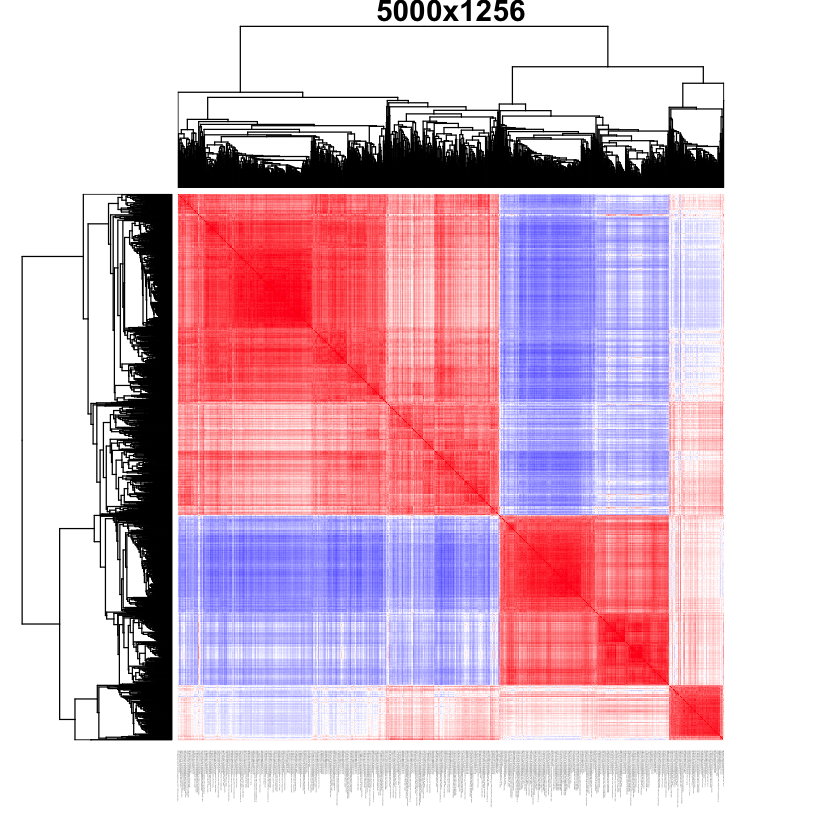

In [4]:
#Calculate Pearson correlation between all tumors based
#on the 5k most variable CpGs
tic("Sample correlation heatmap")
n.var = 5000
b <- allbeta.ordered[1:n.var, ]

#Caluclate Pearson correlations between samples/patients
b.xcor <- cor(b, method="pearson")

# perform hierarchical sample clustering
b.xdend <- as.dendrogram(hclust(as.dist(1-b.xcor), method="average"))

# Visualisation of pre-computed hierarchical sample/patient clustering
cols <- colorRampPalette(c("blue", "white", "red"))(100)
heatmap(b.xcor, Rowv=b.xdend, col=cols, symm=TRUE, zlim=c(-1, 1), scale="none", useRaster=TRUE,
        cexCol=max(min(125*ncol(b)^-1.25, 1), 0.07), labRow=NA, main=paste(dim(b), collapse="x"))
#--> symmetric matrix of similarities between patients
toc()
# 8 min on my M2 2023 macbook pro

t-sne: 86.44 sec elapsed


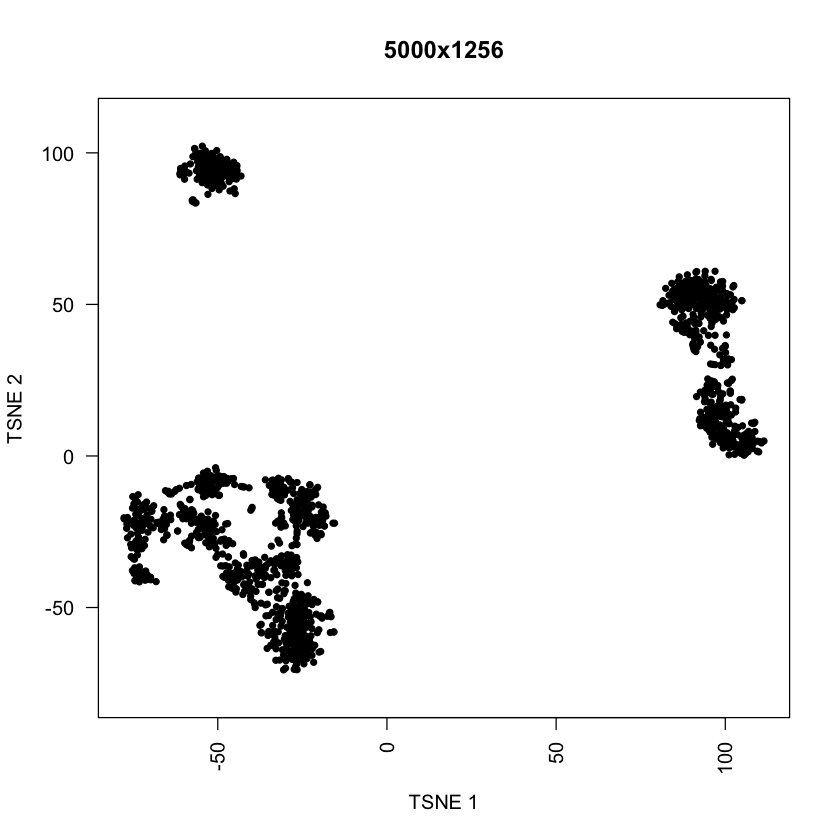

In [5]:
# TSNE -  t-distributed stochastic neigborhood embedding
# non-linear dimension reduction
tic("t-sne")
set.seed("202301")
Y <- Rtsne(as.dist(1-b.xcor), verbose=FALSE, check_duplicates=FALSE, is_distance=TRUE,
             perplexity=min(floor((ncol(b)-1)/3), 30), theta=0, pca=FALSE, max_iter=10000)$Y
Y.range <- apply(Y, 2, range)
Y.diff <- apply(Y.range, 2, diff)
Y.center <- apply(Y.range, 2, mean)
plot(Y, xlim=Y.center[1] + c(-0.5, 0.5)*max(Y.diff), ylim=Y.center[2] + c(-0.5, 0.5)*max(Y.diff),
     xlab="TSNE 1", ylab="TSNE 2", pch=20, cex=1, col="black", main=paste(dim(b), collapse="x"), las=2)
toc()